Loading /home/arthur/dev/streaming-pipeline/data/raw/experiment07/2025-12-19-20_49_14-avro-edge.parquet...
Clustering data into 3 groups (one per Kafka broker)...

Identified Clock Drift per Cluster (ms):
 Cluster 1 (Broker Group): -931.86 ms
 Cluster 0 (Broker Group): 35.28 ms
 Cluster 2 (Broker Group): 110.74 ms


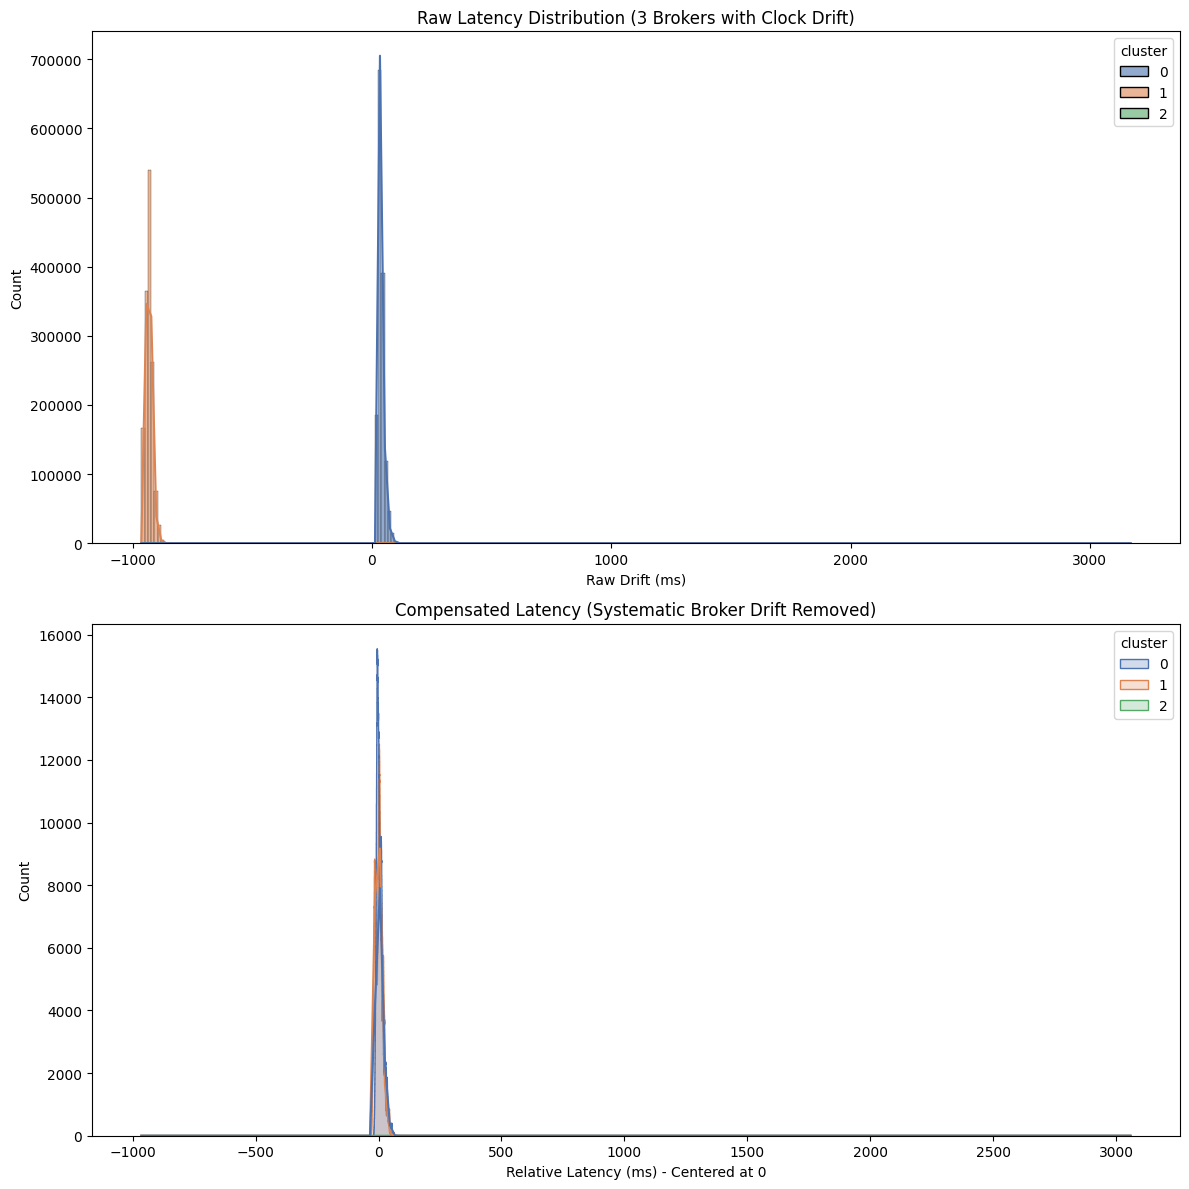


Post-Compensation Descriptive Stats:
count    2.884203e+06
mean     1.666985e+00
std      1.837878e+01
min     -9.649080e+02
25%     -8.196000e+00
50%      0.000000e+00
75%      9.696000e+00
max      3.059218e+03
Name: corrected_drift_ms, dtype: float64
Typical Network Jitter (IQR): 17.89 ms


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from datetime import datetime
import sys
from pathlib import Path

# Add the notebooks directory to the path
sys.path.append(str(Path.cwd().parent))

try:
    from utils import fix_timestamps_timezone
except ImportError:
    # Fallback if utils is not available in current execution context
    def fix_timestamps_timezone(df):
        df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed')
        df['source_timestamp'] = pd.to_datetime(df['source_timestamp'], format='mixed')
        return df

def analyze_kafka_drift(file_path):
    # 1. Load Data
    print(f"Loading {file_path}...")
    df = pd.read_parquet(file_path)

    # 2. Preprocess Timestamps
    df = fix_timestamps_timezone(df)

    # Calculate raw drift in milliseconds
    # drift = Broker Time - Source Time
    df['drift_ms'] = (df['timestamp'] - df['source_timestamp']).dt.total_seconds() * 1000

    # 3. Forced Clustering (3 Clusters for 3 Kafka Brokers)
    # Since you know there are exactly 3 brokers, we force n_components=3.
    # This prevents the GMM from splitting network jitter into "fake" clusters.
    X = df['drift_ms'].values.reshape(-1, 1)
    
    print("Clustering data into 3 groups (one per Kafka broker)...")
    gmm = GaussianMixture(n_components=3, random_state=42, n_init=10)
    df['cluster'] = gmm.fit_predict(X)
    
    # 4. Map Clusters to Brokers/Partitions
    # Typically, a specific partition is handled by a specific broker.
    # Checking 'partition' column helps verify the cluster-to-broker mapping.
    partition_col = next((col for col in df.columns if 'partition' in col.lower()), None)
    
    if partition_col:
        print(f"\nPartition Distribution per Drift Cluster:")
        pivot = df.groupby(['cluster', partition_col]).size().unstack(fill_value=0)
        print(pivot)

    # 5. Calculate Systematic Error Compensation
    # We use the median per cluster to represent the constant 'clock drift'
    cluster_means = df.groupby('cluster')['drift_ms'].median().sort_values().to_dict()
    
    print("\nIdentified Clock Drift per Cluster (ms):")
    for cluster, median in cluster_means.items():
        print(f" Cluster {cluster} (Broker Group): {median:.2f} ms")

    # 6. Compensate Data Points
    # Subtracting the cluster-specific median to align all data to the same time-base
    df['corrected_drift_ms'] = df.apply(
        lambda row: row['drift_ms'] - cluster_means[row['cluster']], axis=1
    )

    # 7. Visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    # Distribution before compensation
    sns.histplot(data=df, x='drift_ms', hue='cluster', kde=True, ax=ax1, 
                 palette='deep', multiple="layer", alpha=0.6)
    ax1.set_title('Raw Latency Distribution (3 Brokers with Clock Drift)')
    ax1.set_xlabel('Raw Drift (ms)')

    # Distribution after compensation
    # We plot the overall distribution and the individual clusters to show alignment
    sns.histplot(data=df, x='corrected_drift_ms', hue='cluster', kde=True, ax=ax2, 
                 palette='deep', element="step")
    ax2.set_title('Compensated Latency (Systematic Broker Drift Removed)')
    ax2.set_xlabel('Relative Latency (ms) - Centered at 0')
    
    plt.tight_layout()
    plt.show()

    return df, cluster_means

if __name__ == "__main__":
    file_name = '/home/arthur/dev/streaming-pipeline/data/raw/experiment07/2025-12-19-20_49_14-avro-edge.parquet'
    try:
        analyzed_df, offsets = analyze_kafka_drift(file_name)
        
        print("\nPost-Compensation Descriptive Stats:")
        print(analyzed_df['corrected_drift_ms'].describe())
        
        # Calculate Inter-Quartile Range to identify real network jitter
        q1 = analyzed_df['corrected_drift_ms'].quantile(0.25)
        q3 = analyzed_df['corrected_drift_ms'].quantile(0.75)
        print(f"Typical Network Jitter (IQR): {q3 - q1:.2f} ms")
        
    except Exception as e:
        print(f"Error processing file: {e}")
        import traceback
        traceback.print_exc()

Loading /home/arthur/dev/streaming-pipeline/data/raw/experiment07/2025-12-19-20_49_14-avro-edge.parquet...

Reference Cluster identified as: 0 (Median: 35.28 ms)

Calculated Clock Offsets (Relative to Reference):
 Cluster 0: +0.00 ms (Reference)
 Cluster 1: -967.13 ms 
 Cluster 2: +75.46 ms 


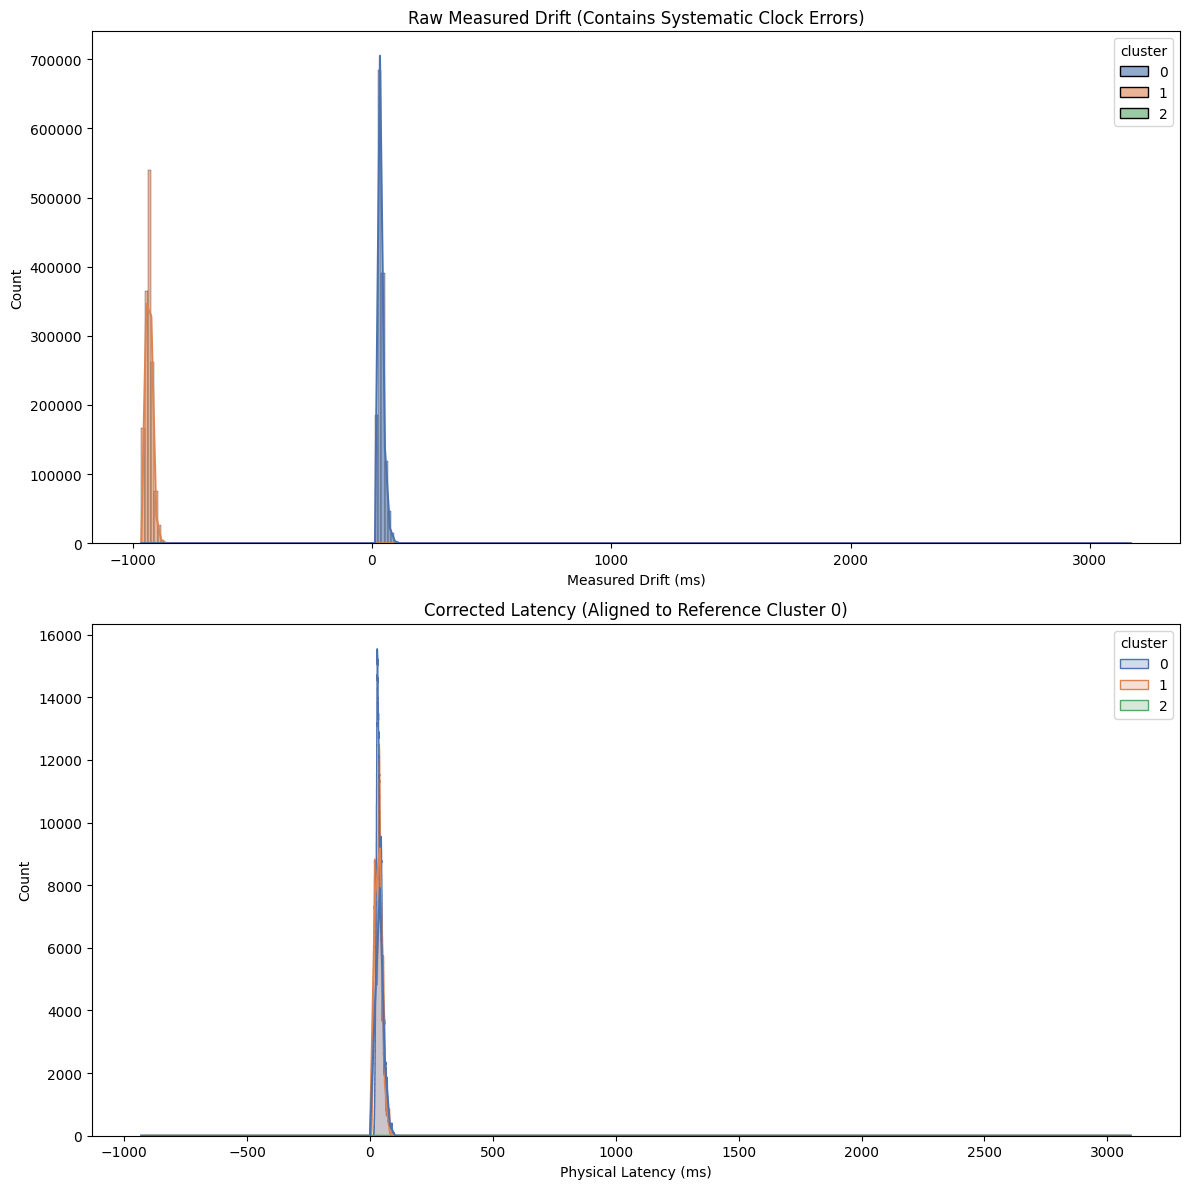


Final Latency Statistics (after broker alignment):
count    2.884203e+06
mean     3.694399e+01
std      1.837878e+01
min     -9.296310e+02
25%      2.708100e+01
50%      3.527700e+01
75%      4.497300e+01
max      3.094495e+03
Name: corrected_latency_ms, dtype: float64



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from datetime import datetime
import sys
from pathlib import Path

# Add the notebooks directory to the path
sys.path.append(str(Path.cwd().parent))

try:
    from utils import fix_timestamps_timezone
except ImportError:
    def fix_timestamps_timezone(df):
        df['timestamp'] = pd.to_datetime(df['timestamp'], format='mixed')
        df['source_timestamp'] = pd.to_datetime(df['source_timestamp'], format='mixed')
        return df

def analyze_kafka_drift(file_path):
    # 1. Load Data
    print(f"Loading {file_path}...")
    df = pd.read_parquet(file_path)

    # 2. Preprocess Timestamps
    df = fix_timestamps_timezone(df)

    # Calculate raw drift (ms): Broker Arrival - Source Generation
    df['raw_drift_ms'] = (df['timestamp'] - df['source_timestamp']).dt.total_seconds() * 1000

    # 3. Clustering (3 Brokers)
    X = df['raw_drift_ms'].values.reshape(-1, 1)
    gmm = GaussianMixture(n_components=3, random_state=42, n_init=10)
    df['cluster'] = gmm.fit_predict(X)
    
    # 4. Define Reference (Cluster 0 as no-drift reference)
    # We find the actual cluster ID that has a median closest to 35.28ms 
    # (to ensure the code remains robust if GMM re-orders labels)
    medians = df.groupby('cluster')['raw_drift_ms'].median()
    ref_cluster = medians.iloc[(medians - 35.28).abs().argsort()[:1]].index[0]
    ref_value = medians[ref_cluster]
    
    print(f"\nReference Cluster identified as: {ref_cluster} (Median: {ref_value:.2f} ms)")

    # 5. Calculate Systematic Error relative to Reference
    # drift_to_compensate = Cluster_Median - Reference_Median
    cluster_offsets = (medians - ref_value).to_dict()
    
    print("\nCalculated Clock Offsets (Relative to Reference):")
    for cluster, offset in cluster_offsets.items():
        note = "(Reference)" if cluster == ref_cluster else ""
        print(f" Cluster {cluster}: {offset:+.2f} ms {note}")

    # 6. Compensate Data Points
    # We only remove the delta between brokers. 
    # This keeps the "real" latency (approx 35ms base) intact.
    df['corrected_latency_ms'] = df.apply(
        lambda row: row['raw_drift_ms'] - cluster_offsets[row['cluster']], axis=1
    )

    # 7. Visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    # Distribution before compensation
    sns.histplot(data=df, x='raw_drift_ms', hue='cluster', kde=True, ax=ax1, 
                 palette='deep', multiple="layer", alpha=0.6)
    ax1.set_title('Raw Measured Drift (Contains Systematic Clock Errors)')
    ax1.set_xlabel('Measured Drift (ms)')

    # Distribution after compensation
    # Now all clusters should align around the ~35ms peak
    sns.histplot(data=df, x='corrected_latency_ms', hue='cluster', kde=True, ax=ax2, 
                 palette='deep', element="step")
    ax2.set_title(f'Corrected Latency (Aligned to Reference Cluster {ref_cluster})')
    ax2.set_xlabel('Physical Latency (ms)')
    
    plt.tight_layout()
    plt.show()

    return df, cluster_offsets

if __name__ == "__main__":
    file_name = '/home/arthur/dev/streaming-pipeline/data/raw/experiment07/2025-12-19-20_49_14-avro-edge.parquet'
    try:
        analyzed_df, offsets = analyze_kafka_drift(file_name)
        
        print("\nFinal Latency Statistics (after broker alignment):")
        stats = analyzed_df['corrected_latency_ms'].describe()
        print(stats)
        
        # Checking for negative values which shouldn't exist in true latency
        neg_count = (analyzed_df['corrected_latency_ms'] < 0).sum()
        if neg_count > 0:
            print(f"\nWarning: {neg_count} points still show negative latency. "
                  "This suggests network jitter larger than the base latency.")

    except Exception as e:
        print(f"Error: {e}")